# Convert the model

In [6]:
import os, random

import numpy as np
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.utils import plot_model

from utils import get_train_data

## Load model

In [8]:
MODEL = 'CNN-Normalized-Stream-01'

model = K.models.load_model(f'../models/{MODEL}')

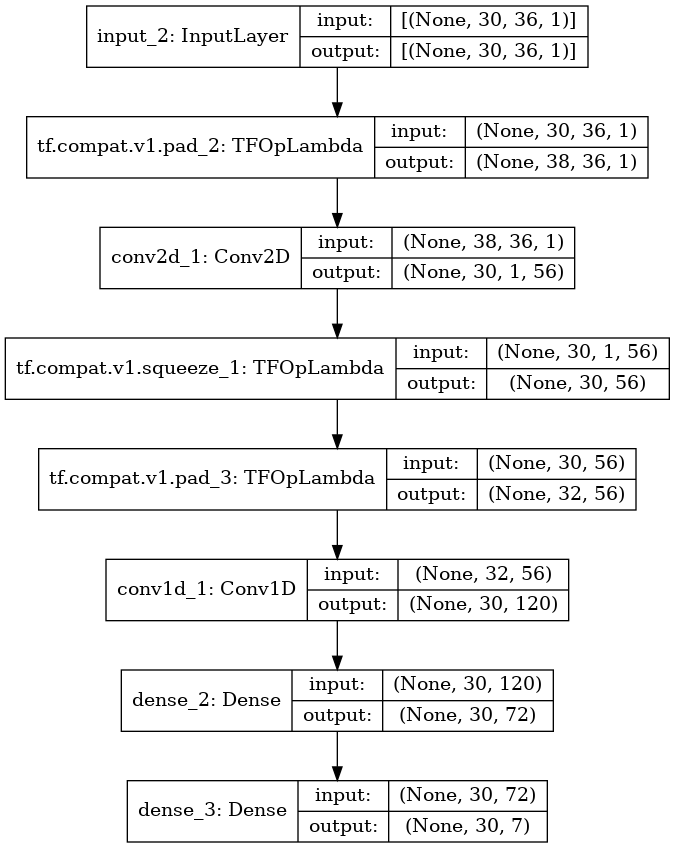

In [9]:
plot_model(model, show_shapes=True, show_layer_names=True)

## Load data

In [3]:
X_train, y_train = get_train_data()

In [4]:
TIME_STEPS = 30 # expect camera 30 fps, so process 1 sample per second

# Number of samples in batch
N_train = X_train.shape[0] // TIME_STEPS 

X_train = X_train[:N_train * TIME_STEPS].reshape(-1, TIME_STEPS, 36)
y_train = y_train[:N_train * TIME_STEPS].reshape(-1, TIME_STEPS, 1)

In [5]:
y_train = K.utils.to_categorical(y_train, num_classes=7)
X_train = tf.constant(X_train)

## Convert and save tflite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model) 

tflite_model = converter.convert()

In [ ]:
# Save the model.
with open(f'../models/{MODEL}/model.tflite', 'wb') as f:
  f.write(tflite_model)

## Test prediction

In [ ]:
# Run the model with TensorFlow to get expected results.
TEST_CASES = 10
x = tf.constant(X_train[:TEST_CASES])

# Run the model with TensorFlow Lite
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

for i in range(TEST_CASES):
    expected = model.predict(x[i:i+1])
    interpreter.set_tensor(input_details[0]["index"], x[i:i+1])
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])

    # Assert if the result of TFLite model is consistent with the TF model.
    np.testing.assert_almost_equal(expected, result, decimal=5)
    print("Done. The result of TensorFlow matches the result of TensorFlow Lite.")

    # Please note: TfLite fused Lstm kernel is stateful, so we need to reset
    # the states.
    # Clean up internal states.
    interpreter.reset_all_variables()